In [2]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd, seaborn as sns; sns.set()
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt, numpy as np
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import taudata_TopicModelling as tauTopic
import taudata_crawl_tweet as tauData

c:\winpython_368\python-3.6.8.amd64\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
# Loading Data from database
dbParT = {'db_': 'u8494347_twitter', 'tbl':'islam_id_2009_2019', 'usr':'u8494347_taufikedys', 'pas':'ppim_UIN_Jakarta', 'hst':'data-university.com'}
fTweets = 'data/agama_2009-2019_27Jan2020.csv'
print('Finished, Exporting data from MySQL to Dataframe ==> CSV')
db = tauData.conMql(dbParT)
query = "SELECT name, created_at, tweet, lat, lon, location FROM {}".format(dbParT['tbl'])
df = pd.read_sql(query, db)
df.to_csv(fTweets, encoding='utf-8', index=False)
db.close()

Finished, Exporting data from MySQL to Dataframe ==> CSV


In [4]:
print(df.shape)
print(df.info)
data = df.tweet.to_list()

(620041, 6)
<bound method DataFrame.info of                        name  created_at  \
0                     RioAP  2010-01-20   
1               A.B. Sadewa  2010-10-25   
2                     Reszz  2010-09-08   
3                   Armalia  2010-11-06   
4        Anggayudha A. Rasa  2010-12-07   
...                     ...         ...   
620036             Archiboo  2014-03-26   
620037                sasaa  2014-03-25   
620038      Red Sin Censura  2014-03-25   
620039       Nubian Goddess  2014-03-25   
620040  M Bob Muharly Rambe  2014-03-25   

                                                    tweet       lat      lon  \
0       saya liberal! Meliberalkan diri dari tahayul b... -0.789275  113.921   
1       Untuk mengurangi kemacetan di jakarta, mari ke... -0.789275  113.921   
2       @firahermana nice tweets. Mungkin film itu bis...       NaN      NaN   
3       RT @luvditz: Liat dude herlino kayanya artis p... -6.917460  107.619   
4       Tolong jelaskan mengapa Al Qur'

In [5]:
# PreProcessing for Topic Modelling 
stopId, lemmaId = tauTopic.LoadStopWords(lang='id') 
slangFixId = tauTopic.loadCorpus(file = 'data/slang.dic', sep=':')
filters = set(['NN', 'NNP', 'NNS', 'NNPS', 'JJ'])

for i, d in tqdm(enumerate(data)):
    doc = tauTopic.cleanText(d, fix=slangFixId, lemma=lemmaId, stops = stopId, symbols_remove = True, min_charLen = 3, max_charLen = 12, fixTag= True, fixMix=True)
    data[i] = tauTopic.NLPfilter(doc,filters)
print(data[:3])


[['liberal', 'tahayul', 'khurafat', 'sekuler', 'liberal', 'kah', 'quran'], ['kemacetan', 'jakarta', 'mari', 'kah', 'quran', 'hadits'], ['firahermana', 'bagus', 'tweets', 'film', 'pendapat', 'kolot', 'kah', 'quran', 'hadits']]


In [6]:
bigram_t = Phrases(data, min_count=10)
trigram_t = Phrases(bigram_t[data])
for idx, d in enumerate(data):
    for token in bigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)
    for token in trigram_t[d]:
        if '_' in token:# Token is a bigram, add to document.
            data[idx].append(token)

# Create a dictionary representation of the documents.
# Remove rare & common tokens
dictionary_t = Dictionary(data)
dictionary_t.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus_t = [dictionary_t.doc2bow(doc) for doc in data]
print('Number of unique tokens: %d' % len(dictionary_t))
print('Number of documents: %d' % len(corpus_t))
print(corpus_t[:1])

Number of unique tokens: 20872
Number of documents: 620041
[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 3)]]


In [13]:
start, step, limit = 2, 1, 20 # Ganti dengan berapa banyak Topic yang ingin di hitung/explore
coh_t, kCV = [], 10 # hati-hati sangat lambat karena cross validation pada metode yang memang tidak efisien (LDA)

for i in tqdm(range(kCV)):
    model_list, c = tauTopic.compute_coherence_values(dictionary=dictionary_t, corpus=corpus_t, texts=data, start=start, limit=limit, step=step)
    coh_t.append(c)
    
coherence_t = np.mean(np.array(coh_t), axis=0)
'Done'

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [36:52<00:00, 120.77s/it]


'Done'

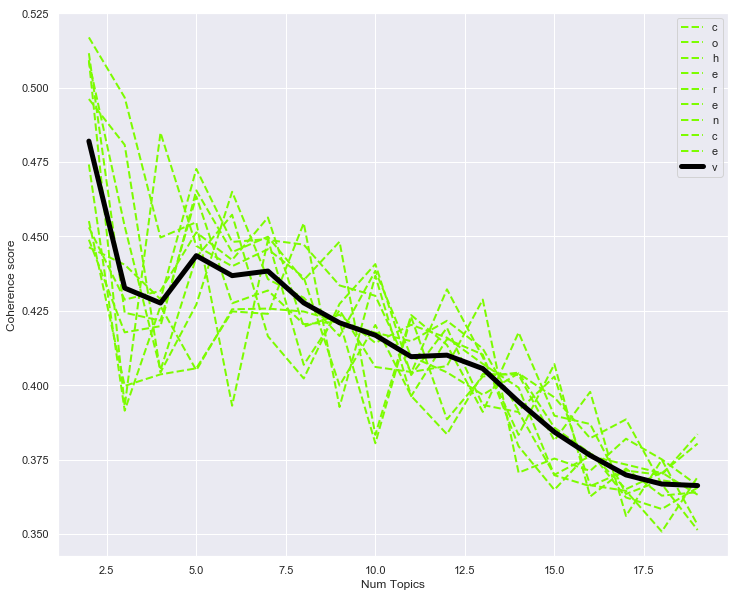

In [14]:
# Show graph
x = range(start, limit, step)
plt.figure(figsize=(12,10))
for c in coh_t:
    plt.plot(x, c, '--', color = 'lawngreen', linewidth = 2)
plt.plot(x, coherence_t, '-', color = 'black', linewidth = 5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

100%|██████████████████████████████████████████████████████████████████████| 620041/620041 [00:00<00:00, 697138.35it/s]


In total there are 2 major topics, distributed as follows


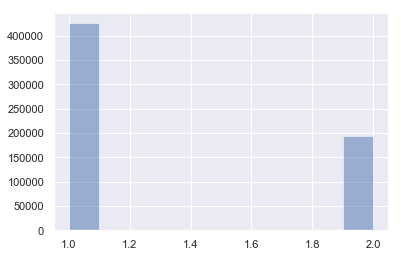

Printing top 2 Topics, with top 15 Words:
Topic #1:
surga praktek kah allah iya ujian dunia syurga tangan riba api keutamaan sorga sariah besok
Topic #2:
orang praktek islam kafir jahil you quran muslim agama this bin khilafah indonesia abi nomor


In [7]:
# Mari kita dalami lebih jauh Topic Pembicaraan ini
k = 2 # Ganti dengan hasil optimal bergantung Graphics diatas
Docs_t = [' '.join(d) for d in data]
tf_w, tm_w, vec_w = tauTopic.getTopics(Docs_t, n_topics=k, Top_Words=15)

In [8]:
# Visualisasi Topic Modelling
pyLDAvis.sklearn.prepare(tf_w, tm_w, vec_w)  

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.260669  0.0       1        1  51.777147
1     -0.260669  0.0       2        1  48.222853, topic_info=      Category          Freq     Term          Total  loglift  logprob
38965  Default  83184.000000    orang   83184.000000  30.0000  30.0000
50769  Default  89952.000000    surga   89952.000000  29.0000  29.0000
20960  Default  22014.000000    islam   22014.000000  28.0000  28.0000
1713   Default  24025.000000    allah   24025.000000  27.0000  27.0000
21241  Default  21748.000000      iya   21748.000000  26.0000  26.0000
...        ...           ...      ...            ...      ...      ...
33599   Topic2   9391.383991   muslim    9397.348845   0.7287  -4.7324
52355   Topic2   4196.482865    teori    4197.367115   0.7291  -5.5380
15911   Topic2   3507.252666     from    3508.078543   0.7291  -5.7174
42774   Topic2  42981.553659  praktek  102439.316358  -0.1392  -3.2115
46795   Topic2   4414.884210   sayang    5247.486743   0.5566  -5.4873

[105 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
190        1  0.000138     abi
190        2  0.999963     abi
531        1  0.999806    adik
531        2  0.000292    adik
763        1  0.000113   agama
...      ...       ...     ...
55585      2  0.020289     via
56060      1  0.999829  wanita
56060      2  0.000209  wanita
57354      1  0.000098     you
57354      2  0.999894     you

[148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# Referensi Pilihan:

* perhitungan Manual Topic Modelling LDA: http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/
* http://mimno.infosci.cornell.edu/slides/details.pdf
* https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
* http://www.umiacs.umd.edu/~jbg/docs/nips2009-rtl.pdf
* http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
* Penjelasan intuitif yang baik: https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d 
* inconjunction dengan interactive program berikut: https://lettier.com/projects/lda-topic-modeling/ 